The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


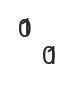

In [22]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt

# Load models together
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
%load_ext autoreload
%autoreload 2
    
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.sim_utils import make_dist_matrix
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.multimodal_datasets import MultimodalMarginalLatentDataset
from src.multimodal_models import BSSVAE, JMVAE
from src.multimodal_train_eval import predict_multimodal
from src.metrics import reconstruction_accuracy, VAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset
import torch
import glob
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180


# Prep TCRBase data using the filtered dataset

In [28]:
filt_df = pd.read_csv('../data/filtered/240418_nettcr_expanded_20binders_17pep_POSONLY.csv')
filt_df['seq_id'] = range(len(filt_df))
filt_df.head()

,Unnamed: 0,peptide,A1,A2,A3,B1,B2,B3,allele,partition,binder,origin,original_peptide,raw_index,reference,source_organism,input_type,db,seq_id
0,0,TTDPSFLGRY,ATGYPS,ATKADDK,ALSGNTDKLI,MDHEN,SYDVKM,ASSLAGGIVDEQF,HLA-A*01:01,1,1,VDJdb,TTDPSFLGRY,VDJdb_69875,https://github.com/antigenomics/vdjdb-db/issue...,SARS-CoV-2,paired,nettcr,0
1,4,ELAGIGILTV,DRGSQS,IYSNGD,AAPQGAGTALI,LGHNA,YSLEER,ASSRALLMGNTIY,HLA-A*02:01,1,1,10x,ELAGIGILTV,ITRAP_4414,37133356,NaN,paired,nettcr,1
2,5,KLGGALQAK,NIATNDY,GYKTK,LVGDMRGGSNYQLI,LGHNA,YSLEER,ASSQDTGTVNSPLH,HLA-A*03:01,3,1,10x,KLGGALQAK,ITRAP_2865,37133356,NaN,paired,nettcr,2
3,6,IVTDFSVIK,YGATPY,YFSGDTLV,AVVQMNSGGYQKVT,MDHEN,SYDVKM,ATRPAGYNEQF,HLA-A*11:01,1,1,10x,IVTDFSVIK,ITRAP_4589,37133356,NaN,paired,nettcr,3
4,7,RAKFKQLL,TISGTDY,GLTSN,IQSQGGSEKLV,SGHDT,YYEEEE,ASSLRDGSEAF,HLA-B*08:01,0,1,10x,RAKFKQLL,ITRAP_366,37133356,NaN,paired,nettcr,4


In [29]:
%rm -r ../data/TCRBASE/tcrbase_expanded_p0_20binders/
%mkdir -p ../data/TCRBASE/tcrbase_expanded_p0_20binders_swapped/


rm: ../data/TCRBASE/tcrbase_expanded_p0_20binders/: No such file or directory


In [30]:
for p in df.peptide.unique():
    query = filt_df.query('peptide==@p and partition==0')[['seq_id','A1','A2','A3','B1','B2','B3']]
    db = filt_df.query('original_peptide==@p and partition!=0 and binder==1')[['seq_id','A1','A2','A3','B1','B2','B3']]
    query.to_csv(f'../data/TCRBASE/tcrbase_expanded_p0_20binders_swapped/{p}_query_p0.tsv', sep='\t', index=False, header=False)
    db.to_csv(f'../data/TCRBASE/tcrbase_expanded_p0_20binders_swapped/{p}_db_p0.tsv', sep='\t', index=False, header=False)

# Reading results and doing plots etc

In [26]:
cols = ['bs1', 'bs2', 'id_query'] + [f'q_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['bs3', 'bs4', 'id_db'] + [f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['score', 'bs5']

df = pd.read_csv('../output/TCRBASE/tcrbase_expanded_p0_20binders_swapped/ATDALMTGF.txt', comment='#', sep='\s', 
            header=None, names = cols).drop(columns=[f'bs{i}' for i in range(1,6)])
df.set_index('id_query')[

,id_query,q_A1,q_A2,q_A3,q_B1,q_B2,q_B3,id_db,db_A1,db_A2,db_A3,db_B1,db_B2,db_B3,score
0,94,TSDQSYG,QGSYDEQN,AMREGRNSSYKLI,SGHTA,FQGNSA,ASSLVGAGNDEQY,4702,DSAIYN,IQSSQRE,AVRPTGGFKTI,SGHTA,FQGNSA,ASSLVGQLDEQY,10.328103
1,117,DSAIYN,IQSSQRE,AVCEEGSQGNLI,SEHNR,FQNEAQ,ASSLEGQLYEQY,6582,DSAIYN,IQSSQRE,AVKDGGSQGNLI,SEHNR,FQNEAQ,ASSFDSQLYEQY,11.192282
2,968,DSAIYN,IQSSQRE,AVRNTGGFKTI,SGHAT,FQNNGV,ASSLSGQLDTQY,4677,DSAIYN,IQSSQRE,AVFNTGGFKTI,SGHAT,FQNNGV,ASSVTGQLDEQY,11.524290
3,1077,KALYS,LLKGGEQ,GRQSKFWGLPESY,LNHNV,YYDKDF,ATSFTGTAYEQY,186,TRDTTYY,RNSFDEQN,ALSEWNTGFQKLV,MNHEY,SMNVEV,ASSLTSGTYEQY,9.929686
4,1933,SSVPPY,YTSAATLV,AVSLLNYGGSQGNLI,SGDLS,YYNGEE,ASSENTANTGELF,4438,DRGSQS,IYSNGD,AVIAINSGYALN,SGDLS,YYNGEE,ASSENTANTGELF,10.778625
5,2060,DRGSQS,IYSNGD,AVWAGNQFY,MNHEY,SVGEGT,ASSYPRTASNQPQH,2803,DRGSQS,IYSNGD,AVKGNTGFQKLV,KGHSY,FQNENV,ASSPTTESYEQY,10.172104
6,2063,NTAFDY,IRPDVSE,AAKAAGNKLT,LNHDA,SQIVND,ASSTQVIGNQPQH,2764,NSAFQY,TYSSGN,AMSAGSYQLT,LNHDA,SQIVND,ASSTQVIGNQPQH,11.235313
7,2120,TSESDYY,QEAYKQQN,AYRTPYGGSQGNLI,DFQATT,SNEGSKA,SARDLSSSNQPQH,195,TSESDYY,QEAYKQQN,AYRTPYGGSQGNLI,DFQATT,SNEGSKA,SARPRESSNQPQH,11.563166
8,2300,TSGFNG,NVLDGL,AVRDLYGSSASKII,MDHEN,SYDVKM,ASSLNRPDRASYEQY,4786,SSVPPY,YTSAATLV,AVSEGGNKLV,MDHEN,SYDVKM,ASSLSQGALYEQY,9.986141
9,2513,SIFNT,LYKAGEL,AGQVSNNNDMR,SEHNR,FQNEAQ,ASSSLERSFGEAF,6077,SIFNT,LYKAGEL,AGLDDSWGKLQ,SEHNR,FQNEAQ,ASSSLDSYNEQF,10.519942


In [20]:
def read_tcrbase_results(peptide, original_df, dir='../output/tcrbase_expanded_p0_swapped/'):
    cols = ['xx', 'xy', 'id_query'] + [f'q_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['bs1', 'hit', 'id_db'] + [f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['score', 'bs2']
    df = pd.read_csv(f'{dir}{peptide}.txt', comment='#', sep='\s', header=None, names=cols)
    results = pd.merge(df.set_index('id_query')[['score', 'id_db']+[f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']]],
                       original_df[['binder', 'peptide', 'A1','A2','A3','B1','B2','B3']],
                       left_index=True, right_index=True)
    print(peptide, round(roc_auc_score(results['binder'], results['score']),4))
    tcrbase_metrics = {'peptide':peptide, 
                       'method':'tcrbase',
                       'n_pos':len(original_df.query('original_peptide==@peptide and partition==0'))}
    tcrbase_metrics.update(get_metrics(results['binder'], results['score'], round_digit=5))
    print(tcrbase_metrics)
    return tcrbase_metrics, results
    
def read_tcrvae_results(peptide, original_df, dir):
    csv_file = glob.glob(f'{dir}*{peptide}*.csv')[0]
    df = pd.read_csv(csv_file)
    df['binder']=df['label']
    df['score'] = 1- df['min_dist']
    metrics = {'peptide':peptide, 'method':'_'.join(os.path.basename(csv_file).split('_')[5:]), 
               'n_pos':len(original_df.query('original_peptide==@peptide and partition==0 and binder==0'))}
    metrics.update(get_metrics(df['label'], df['score']))
    return metrics, df

def get_model(folder, map_location='cpu'):
    pt = glob.glob(folder+'/*checkpoint_best*.pt')
    pt = [x for x in pt if 'interval' not in x][0]
    js = glob.glob(folder+'/*checkpoint*.json')[0]
    model = load_model_full(pt, js, map_location='cpu')
    # Extract the vae part if the model comes from a two stage VAE
    if type(model)==TwoStageVAECLF:
        model = model.vae
    model.eval()
    return model

    
def read_tcrbase_results_folds(peptide, original_df, partition, dir='../output/tcrbase_expanded_p0_swapped/'):
    cols = ['xx', 'xy', 'id_query'] + [f'q_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['bs1', 'hit', 'id_db'] + [f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['score', 'bs2']
    df = pd.read_csv(f'{dir}{peptide}_p{partition}.txt', comment='#', sep='\s', header=None, names=cols)

    template_df = original_df.query('partition==@partition and peptide==@peptide')
    template_df = template_df.set_index('fulltcr')[['binder', 'peptide', 'A1','A2','A3','B1','B2','B3']]
    df['fulltcr'] = df['q_A1']+df['q_A2']+df['q_A3']+df['q_B1']+df['q_B2']+df['q_B3']
    results = pd.merge(df.set_index('fulltcr')[['score', 'id_db']+[f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']]],
                       template_df, left_index=True, right_index=True)
    return results

def get_tcrbase_concat(peptide, original_df, dir):
    df = pd.concat([read_tcrbase_results_folds(peptide, original_df, partition, dir) for partition in range(5)])
    df['score_scaled'] = df['score'] / 12
    res = {'peptide':peptide}
    res.update(get_metrics(df['binder'], df['score_scaled'], no_curves=True))
    return res

In [23]:
read_tcrbase_results('ELAGIGILTV', df, '../output/TCRBASE/tcrbase_expanded_p0_20binders_swapped/')

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [4]:
import pandas as pd
import numpy as np

newpeps = df.peptide.unique()

ntr = []
for f in glob.glob('../output/240403_MMVAE_TCRBASE/*/'):
    for p in newpeps:
        ntr.append(read_tcrvae_results(p, new_df, f)[0])

old = []
for f in glob.glob('../output/240403_oldExpVAE_TCRBASE/*/'):
    for p in newpeps:
        old.append(read_tcrvae_results(p, new_df, f)[0])
old = pd.DataFrame(old)
ntr = pd.DataFrame(ntr)
tcrbase_results['method'] = 'TCRBase'
cat = pd.concat([tcrbase_results, old, ntr])
cat['weight'] = cat['peptide'].apply(lambda x: len(new_df.query('peptide==@x')) / len(new_df))

# Define a function to calculate the multiple operations
def calculate_metrics(x):
    normal_avg_auc = x['auc'].mean()
    weighted_avg_auc = np.average(x['auc'], weights=x['weight'])
    normal_avg_auc_01 = x['auc_01'].mean()
    weighted_avg_auc_01 = np.average(x['auc_01'], weights=x['weight'])
    return pd.Series({
        'normal_avg_auc': normal_avg_auc,
        'weighted_avg_auc': weighted_avg_auc,
        'normal_avg_auc_01': normal_avg_auc_01,
        'weighted_avg_auc_01': weighted_avg_auc_01
    })

# Group by the 'group' column and apply the custom calculation function
result = cat.groupby('method').apply(calculate_metrics).reset_index()

result.sort_values('normal_avg_auc',ascending=False)


NameError: name 'newpeps' is not defined

In [ ]:
tbcr_dist = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/

In [ ]:
new_tcrbase_results = []
for peptide in new_df.groupby('peptide').agg(c=('B3','count')).sort_values('c',ascending=False).index:
    res = get_tcrbase_concat(peptide, new_df, '../output/TCRBASE/tcrbase_expanded_ALL_swapped/')
    new_tcrbase_results.append(res)
new_tcrbase_results = pd.DataFrame(new_tcrbase_results)

In [ ]:
def make_3_plots(peptide, original_df, dir_old, dir_new, dir_tcrbase='../output/TCRBASE/tcrbase_expanded_p0_swapped/',
                 name_old=None, name_new=None, name_tcrbase='TCRBase', bins=100):
    _, tcrbase_df = read_tcrbase_results(peptide, original_df, dir_tcrbase)
    _, tcrold_df = read_tcrvae_results(peptide, original_df, dir_old)
    _, tcrnew_df = read_tcrvae_results(peptide, original_df, dir_new)
    
    f,a = plt.subplots(1,3, figsize=(15,4.5))
    ax = a.ravel()
    name_old = 'Old VAE' if name_old is None else name_old
    name_new = 'New MMVAE' if name_new is None else name_new
    tcrbase_auc = roc_auc_score(tcrbase_df['binder'], tcrbase_df['score'])
    tcrold_auc = roc_auc_score(tcrold_df['binder'], tcrold_df['score'])
    tcrnew_auc = roc_auc_score(tcrnew_df['binder'], tcrnew_df['score'])
    

    sns.histplot(data = tcrbase_df.rename(columns={'score':'seq_similarity'}), x='seq_similarity', hue='binder', ax=ax[0], kde=False, stat='percent', common_norm=False, bins=bins, alpha=0.75)
    ax[0].set_title(f'{name_tcrbase}\nAUC = {tcrbase_auc:.4f}', fontweight='semibold',fontsize=13)
    sns.histplot(data = tcrold_df.rename(columns={'score':'cos_similarity'}), x='cos_similarity', hue='binder', ax=ax[1], kde=False, stat='percent', common_norm=False, bins=bins, alpha=0.75)
    ax[1].set_title(f'{name_old}\nAUC = {tcrold_auc:.4f}', fontweight='semibold',fontsize=13)
    sns.histplot(data = tcrnew_df.rename(columns={'score':'cos_similarity'}), x='cos_similarity', hue='binder', ax=ax[2], kde=False, stat='percent', common_norm=False, bins=bins, alpha=0.75)
    ax[2].set_title(f'{name_new}\nAUC = {tcrnew_auc:.4f}', fontweight='semibold',fontsize=13)

    # Align plot2 and 3 on xlim
    ax0_xlim = ax[1].get_xlim()
    ax1_xlim = ax[2].get_xlim()
    new_xlim = [min(ax0_xlim[0], ax1_xlim[0]), max(ax0_xlim[1], ax1_xlim[1])]
    ax[1].set_xlim(new_xlim)
    ax[2].set_xlim(new_xlim)
    f.suptitle(f'Pep: {peptide}', fontweight='semibold', fontsize=14)
    f.tight_layout()
    return ax

In [914]:
def do_tcrbase_and_histplots_local(dist_matrix, peptide, f=None, ax=None, unique_filename=None, outdir=None, bins=100):
    query = dist_matrix.query('set=="query"')
    database = dist_matrix.query('set=="database"')
    db_tcrs = database.index.tolist()
    # Scoring query against database & splitting by label
    pos = query[db_tcrs + ['binder']].query('binder==1')
    neg = query[db_tcrs + ['binder']].query('binder==0')
    tcrbase_output = pd.concat([pos, neg])
    pos = pos.drop(columns=['binder']).values
    neg = neg.drop(columns=['binder']).values

    # Getting the AUC for labelling and output DF ;
    pos_out = tcrbase_output.query('binder==1').drop(columns=['binder'])
    neg_out = tcrbase_output.query('binder!=1').drop(columns=['binder'])
    pos_out = pos_out.apply(lambda x: [np.min(x), x.index[int(np.argmin(x))]], axis=1, result_type='expand').rename(
        columns={0: 'min_dist', 1: 'most_similar'})
    neg_out = neg_out.apply(lambda x: [np.min(x), x.index[int(np.argmin(x))]], axis=1, result_type='expand').rename(
        columns={0: 'min_dist', 1: 'most_similar'})
    cat_out = pd.concat([pos_out.assign(label=1), neg_out.assign(label=0)])
    auc = roc_auc_score(cat_out['label'], 1 - cat_out['min_dist'])

    # Plot both the distribution of scores and the "best" score as done above
    #   Plotting distribution of all scores
    pos_flat = pos.flatten()
    neg_flat = neg.flatten()
    cat = np.concatenate([pos_flat, neg_flat])
    labels = np.concatenate([np.array(['pos'] * len(pos_flat) + ['neg'] * len(neg_flat))])
    df_plot_allvsall = pd.DataFrame(data=np.stack([cat, labels]).T, columns=['distance', 'label'])
    df_plot_allvsall['distance'] = df_plot_allvsall['distance'].astype(float)
    pal = sns.color_palette('gnuplot2', 4)
    sns.set_palette([pal[-1], pal[0]])
    sns.set_style('darkgrid')

    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(9, 5))
    sns.histplot(data=df_plot_allvsall, x='distance', hue='label', ax=ax, kde=False,
                 stat='percent', common_norm=False, bins=bins, alpha=0.75)
    # ax.set_xlim([0,1.1])
    ax.set_title(f'TCRBase: All vs All {peptide}: {auc:.4f}', fontsize=14, fontweight='semibold')
    if unique_filename is not None:
        outdir = './' if outdir is None else outdir
        f.savefig(f'{outdir}{peptide}_AvA_TCRBase_distances_histplot_{unique_filename}', dpi=150,
                  bbox_inches='tight')

    #   Plotting "Best" score
    pos_best = pos.min(axis=1).flatten()
    neg_best = neg.min(axis=1).flatten()
    cat_best = np.concatenate([pos_best, neg_best])
    labels_best = np.concatenate([np.array(['pos'] * len(pos_best) + ['neg'] * len(neg_best))])
    df_plot_best = pd.DataFrame(data=np.stack([cat_best, labels_best]).T, columns=['distance', 'label'])
    df_plot_best['distance'] = df_plot_best['distance'].astype(float)
    f2, ax2 = plt.subplots(1, 1, figsize=(9, 5))
    bins = max(int(len(query.query('binder==1')) / 9), 25)

    sns.histplot(data=df_plot_best, x='distance', hue='label', ax=ax2, kde=False,
                 stat='percent', common_norm=False, bins=bins, alpha=0.75)
    # ax.set_xlim([0,1.1])

    ax2.set_title(f'TCRBase: Best score {peptide}, AUC = {auc:.4f}', fontsize=14, fontweight='semibold')
    if unique_filename is not None:
        outdir = './' if outdir is None else outdir
        f2.savefig(f'{outdir}{peptide}_Best_TCRBase_distances_histplot_{unique_filename}', dpi=150, bbox_inches='tight')

    return cat_out